In [30]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV


In [31]:
# Load the CSV files into Pandas DataFrames
eventFile = os.path.join('..', 'iot-datasets', 'event_type.csv')
event_df = pd.read_csv(eventFile)

logFile = os.path.join('..', 'iot-datasets', 'log_feature.csv')
log_df = pd.read_csv(logFile)

resourceFile = os.path.join('..', 'iot-datasets', 'resource_type.csv')
resource_df = pd.read_csv(resourceFile)

severityFile = os.path.join('..', 'iot-datasets', 'severity_type.csv')
severity_df = pd.read_csv(severityFile)

trainFile = os.path.join('..', 'iot-datasets', 'train.csv')
train_df = pd.read_csv(trainFile)

# Merge DataFrames based on the 'id' column
merged_df = train_df.merge(event_df, on='id', how='left')
merged_df = merged_df.merge(log_df, on='id', how='left')
merged_df = merged_df.merge(resource_df, on='id', how='left')
merged_df = merged_df.merge(severity_df, on='id', how='left')

In [32]:
# Data Cleaning

# Check for missing values
missing_values = merged_df.isna().sum()
missing_values

id                0
location          0
fault_severity    0
event_type        0
log_feature       0
volume            0
resource_type     0
severity_type     0
dtype: int64

In [33]:
merged_df.head(10)

,id,location,fault_severity,event_type,log_feature,volume,resource_type,severity_type
0,14121,location 118,1,event_type 34,feature 312,19,resource_type 2,severity_type 2
1,14121,location 118,1,event_type 34,feature 232,19,resource_type 2,severity_type 2
2,14121,location 118,1,event_type 35,feature 312,19,resource_type 2,severity_type 2
3,14121,location 118,1,event_type 35,feature 232,19,resource_type 2,severity_type 2
4,9320,location 91,0,event_type 34,feature 315,200,resource_type 2,severity_type 2
5,9320,location 91,0,event_type 34,feature 235,116,resource_type 2,severity_type 2
6,9320,location 91,0,event_type 35,feature 315,200,resource_type 2,severity_type 2
7,9320,location 91,0,event_type 35,feature 235,116,resource_type 2,severity_type 2
8,14394,location 152,1,event_type 35,feature 221,1,resource_type 2,severity_type 2
9,14394,location 152,1,event_type 35,feature 301,1,resource_type 2,severity_type 2


In [34]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61839 entries, 0 to 61838
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              61839 non-null  int64 
 1   location        61839 non-null  object
 2   fault_severity  61839 non-null  int64 
 3   event_type      61839 non-null  object
 4   log_feature     61839 non-null  object
 5   volume          61839 non-null  int64 
 6   resource_type   61839 non-null  object
 7   severity_type   61839 non-null  object
dtypes: int64(3), object(5)
memory usage: 4.2+ MB


In [35]:
merged_df.describe()

,id,fault_severity,volume
count,61839.000000,61839.000000,61839.000000
mean,9104.379469,0.549168,8.390336
std,5387.274195,0.727701,22.902491
min,1.000000,0.000000,1.000000
25%,4353.000000,0.000000,1.000000
50%,8981.000000,0.000000,2.000000
75%,13664.000000,1.000000,6.000000
max,18550.000000,2.000000,877.000000


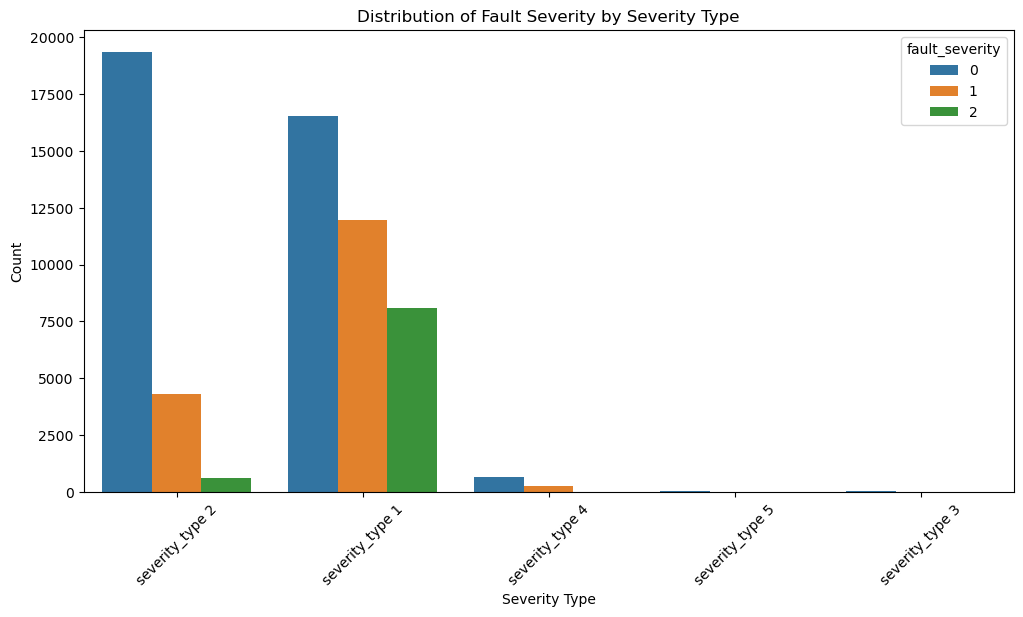

In [36]:
plt.figure(figsize=(12, 6))
sns.countplot(data=merged_df, x='severity_type', hue='fault_severity')
plt.title('Distribution of Fault Severity by Severity Type')
plt.xlabel('Severity Type')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [37]:
severity_summary = merged_df.groupby('severity_type')['fault_severity'].describe()
severity_summary

,count,mean,std,min,25%,50%,75%,max
severity_type,,,,,,,,
severity_type 1,36571.0,0.769954,0.787682,0.0,0.0,1.0,1.0,2.0
severity_type 2,24260.0,0.227865,0.475821,0.0,0.0,0.0,0.0,2.0
severity_type 3,33.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
severity_type 4,920.0,0.277174,0.447847,0.0,0.0,0.0,1.0,1.0
severity_type 5,55.0,0.345455,0.479899,0.0,0.0,0.0,1.0,1.0


In [38]:
# Data Encoding
merged_data_encoded = pd.get_dummies(merged_df, columns=['location', 'event_type', 'log_feature', 'resource_type', 'severity_type'])
merged_data_encoded

,id,fault_severity,volume,location_location 1,location_location 10,location_location 100,location_location 1000,location_location 1002,location_location 1005,location_location 1006,...,resource_type_resource_type 5,resource_type_resource_type 6,resource_type_resource_type 7,resource_type_resource_type 8,resource_type_resource_type 9,severity_type_severity_type 1,severity_type_severity_type 2,severity_type_severity_type 3,severity_type_severity_type 4,severity_type_severity_type 5
0,14121,1,19,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,14121,1,19,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,14121,1,19,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,14121,1,19,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,9320,0,200,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61834,15189,0,10,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
61835,15189,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
61836,17067,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
61837,17067,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [39]:
# Define target variable (fault_severity) and feature variables (X)
X = merged_data_encoded.drop(columns=['fault_severity'])
y = merged_data_encoded['fault_severity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Selection and Training
# Initialize and train the model 
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [40]:
# Model Evaluation
# Evaluate the model's performance on the test data

# Make predictions
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.841930789133247


In [41]:
# Generate a classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
report

Classification Report:


'              precision    recall  f1-score   support\n\n           0       0.88      0.91      0.89      7362\n           1       0.79      0.72      0.75      3301\n           2       0.77      0.78      0.78      1705\n\n    accuracy                           0.84     12368\n   macro avg       0.81      0.80      0.81     12368\nweighted avg       0.84      0.84      0.84     12368\n'

In [42]:
# Create a confusion matrix
confusion = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
confusion

Confusion Matrix:


array([[6707,  465,  190],
       [ 727, 2377,  197],
       [ 202,  174, 1329]], dtype=int64)

In [43]:
# Define a grid of hyperparameters to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model (e.g., RandomForestClassifier)
tuned_model = RandomForestClassifier(random_state=42)

# Create a grid search object with cross-validation
grid_search = GridSearchCV(estimator=tuned_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Perform the grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model with the optimal hyperparameters
best_model = grid_search.best_estimator_

# Fit the best model on the training data
best_model.fit(X_train, y_train)

# Evaluate the tuned model on the test data
y_pred_tuned = best_model.predict(X_test)

# Calculate accuracy of the tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print("Accuracy of Tuned Model:", accuracy_tuned)


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy of Tuned Model: 0.8477522639068564
